# Árbol de Decisión para el Análisis de Pymes (SME)
### Replicando el flujo de Orange Data Mining en Python

Este notebook ha sido diseñado con fines didácticos para estudiantes de Ciencia de Datos. El objetivo es replicar paso a paso el flujo de trabajo realizado en Orange para entrenar un modelo que prediga si una empresa está de alta en el SAT (`altaSAT`), utilizando técnicas de preprocesamiento, selección de variables por Ganancia de Información (IG), sintonización de hiperparámetros y evaluación con curvas ROC/AUC.

---

## 1. Configuración del Entorno
Primero, importamos las librerías necesarias para el análisis de datos, modelado y visualización premium.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_curve, auc, confusion_matrix, classification_report
)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Configuración estética premium
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 100
ALLIANZ_BLUE = '#003882'
VIBRANT_PURPLE = '#7153ff'
PURE_WHITE = '#FFFFFF'

## 2. Carga y Filtrado de Datos (Widget: File -> Select Rows)
En Orange, el widget **Select Rows** nos permite filtrar los datos. Aquí eliminaremos las filas donde `altaSAT` sea igual a 'o' y nos quedaremos con 's' (Si) y 'n' (No).

In [2]:
# Cargar el dataset
path = 'data/sme_mx.csv'
df = pd.read_csv(path)

# Filtrar altaSAT <> 'o'
df_filtered = df[df['altaSAT'] != 'o'].copy()

# Mapear el target a binario: 's' -> 1 (Evento), 'n' -> 0 (No Evento)
df_filtered['target'] = df_filtered['altaSAT'].map({'s': 1, 'n': 0})

print(f"Registros originales: {df.shape[0]}")
print(f"Registros tras filtrado: {df_filtered.shape[0]}")
df_filtered[['altaSAT', 'target']].head()

Registros originales: 885
Registros tras filtrado: 778


,altaSAT,target
0,s,1
1,s,1
2,s,1
3,s,1
4,s,1


## 3. Preprocesamiento (Widget: Select Columns)
Eliminaremos columnas irrelevantes como `id`, `latitud`, `longitud` y textos libres que no aportan al modelo estructurado, para centrarnos en las variables categóricas y numéricas.

In [3]:
# Seleccionamos columnas potencialmente útiles (excluyendo IDs y textos libres complejos)
cols_to_keep = [
    'edadEmprendedor', 'sexoEmprendedor', 'escolaridadEmprendedor', 
    'dependientesEconomicos', 'estadoCivil', 'familiaAyuda', 
    'antiguedadNegocio', 'giroNegocio', 'numEmpleados', 
    'ventasPromedioDiarias', 'registroVentas', 'registroContabilidad', 
    'usaCredito', 'tiempoCreditoProveedores', 'target'
]

df_model = df_filtered[cols_to_keep].dropna().copy()

# Tratamiento de variables categóricas para Sklearn
# Sklearn requiere que los datos sean numéricos.
X = df_model.drop(columns=['target'])
y = df_model['target']

# Identificar variables categóricas
cat_cols = X.select_dtypes(include=['object']).columns

# Aplicar One-Hot Encoding (Equivalente al manejo automático de Orange)
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

print(f"Variables tras One-Hot Encoding: {X_encoded.shape[1]}")

Variables tras One-Hot Encoding: 106


/var/folders/b2/142kycp96wdg69k6pkw9_vf00000gp/T/ipykernel_6870/723353092.py:18: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = X.select_dtypes(include=['object']).columns


## 4. Ranking de Variables (Widget: Rank - Information Gain)
Orange utiliza la métrica de Ganancia de Información para rankear variables. En Python, utilizamos `mutual_info_classif` para replicar este comportamiento y seleccionar las 5 variables más potentes.

Top 5 Variables seleccionadas (Rank):
1. ventasPromedioDiarias (IG: 0.0590)
2. registroVentas_en un sistema especial (IG: 0.0537)
3. registroContabilidad_no registro (IG: 0.0496)
4. estadoCivil_union libre (IG: 0.0495)
5. giroNegocio_servicios  personales(estéticas, spa, uñas, barberías, etc) (IG: 0.0461)


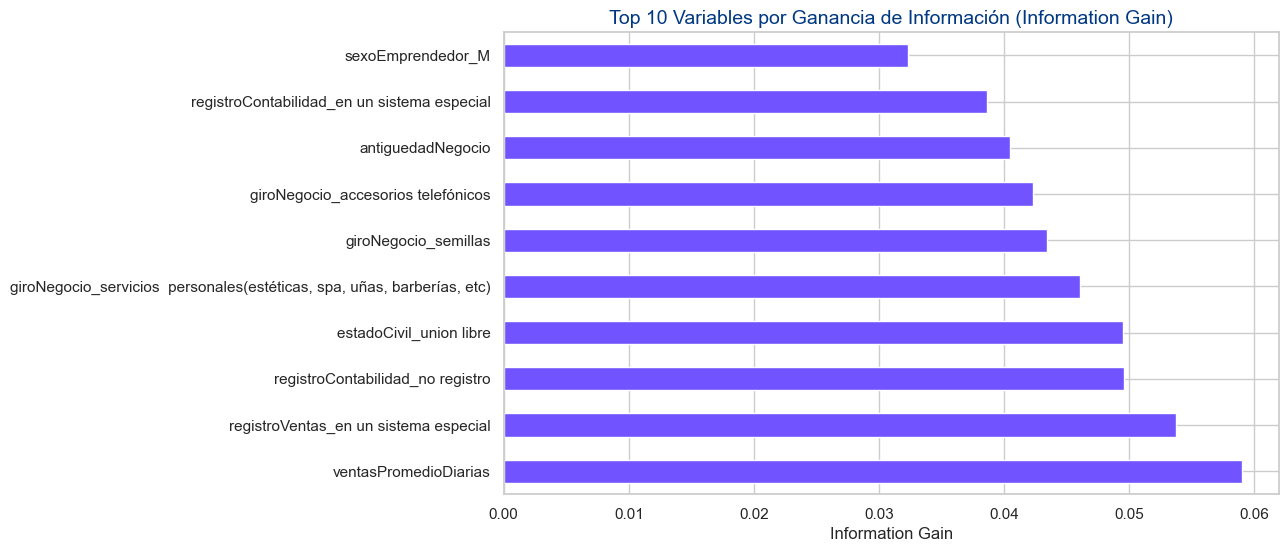

In [4]:
# Calcular Ganancia de Información (Mutual Information)
importances = mutual_info_classif(X_encoded, y, random_state=42)
feat_importances = pd.Series(importances, index=X_encoded.columns)

# Seleccionar las Top 5
top_5_features = feat_importances.nlargest(5).index.tolist()

print("Top 5 Variables seleccionadas (Rank):")
for i, feat in enumerate(top_5_features, 1):
    print(f"{i}. {feat} (IG: {feat_importances[feat]:.4f})")

# Visualización del Ranking
plt.figure(figsize=(10, 6))
feat_importances.nlargest(10).plot(kind='barh', color=VIBRANT_PURPLE)
plt.title("Top 10 Variables por Ganancia de Información (Information Gain)", color=ALLIANZ_BLUE, fontsize=14)
plt.xlabel("Information Gain")
plt.show()

## 5. Partición del Data (Widget: Data Sampler)
Realizamos una partición 70% entrenamiento y 30% prueba.

In [5]:
X_top5 = X_encoded[top_5_features]
X_train, X_test, y_train, y_test = train_test_split(X_top5, y, test_size=0.30, random_state=42, stratify=y)

print(f"Set de Entrenamiento: {X_train.shape[0]} registros")
print(f"Set de Prueba: {X_test.shape[0]} registros")

Set de Entrenamiento: 497 registros
Set de Prueba: 213 registros


## 6. Híper-parametrización y Entrenamiento (Widget: Tree)
Buscamos la mejor configuración del árbol. En Orange configuramos los parámetros manualmente; aquí optimizamos automáticamente usando `GridSearchCV`.

In [11]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6, 8, 10, None],
    'min_samples_split': [0.05, 0.075, 0.1],
    'min_samples_leaf': [0.05, 0.075, 0.1]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

best_tree = grid_search.best_estimator_
print(f"Mejores Hiperparámetros encontrados: {grid_search.best_params_}")

Mejores Hiperparámetros encontrados: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 0.05, 'min_samples_split': 0.05}


## 7. Visualización del Árbol (Widget: Tree Viewer)
Mostramos el árbol con colores bonitos que representan la pureza de las clases.

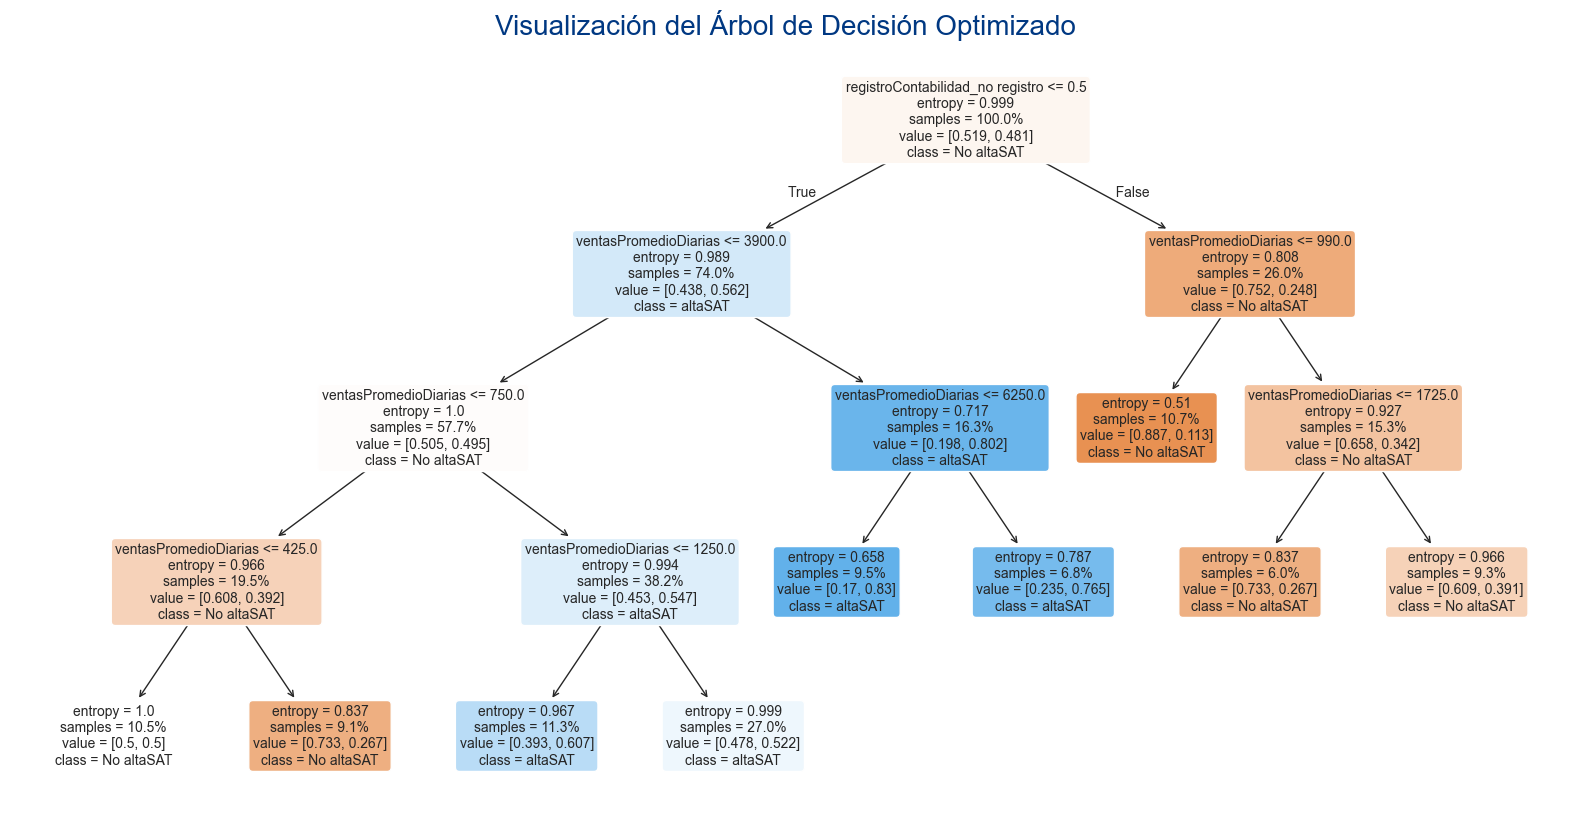

In [12]:
plt.figure(figsize=(20, 10))
plot_tree(best_tree, 
          feature_names=top_5_features, 
          class_names=['No altaSAT', 'altaSAT'], 
          filled=True, 
          rounded=True, 
          proportion=True,
          fontsize=10) # Colores vibrantes
plt.title("Visualización del Árbol de Decisión Optimizado", fontsize=20, color=ALLIANZ_BLUE)
plt.show()

## 8. Evaluación de Modelos (Widget: Test and Score)
Replicamos las métricas que veríamos en el widget **Test and Score**.

In [13]:
y_pred = best_tree.predict(X_test)
y_prob = best_tree.predict_proba(X_test)[:, 1]

print("Resumen de Métricas de Entrenamiento:")
print("------------------------------------")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")

Resumen de Métricas de Entrenamiento:
------------------------------------
Accuracy:  0.6479
Precision: 0.6148
Recall:    0.7282
F1 Score:  0.6667


### Glosario de Métricas para Estudiantes:
1. **Accuracy (Exactitud):** Fracción de predicciones correctas entre el total.
2. **Precision (Precisión):** ¿De todos los que predijimos como 'positivo', cuántos realmente lo eran?
3. **Recall (Sensibilidad):** ¿De todos los que REALMENTE eran positivos, cuántos logramos capturar?
4. **F1-Score:** El promedio armónico entre Precision y Recall. Ideal para clases desbalanceadas.


## 9. Curva ROC y AUC (Widget: ROC Analysis)
La curva ROC nos permite ver la capacidad de discriminación del modelo.

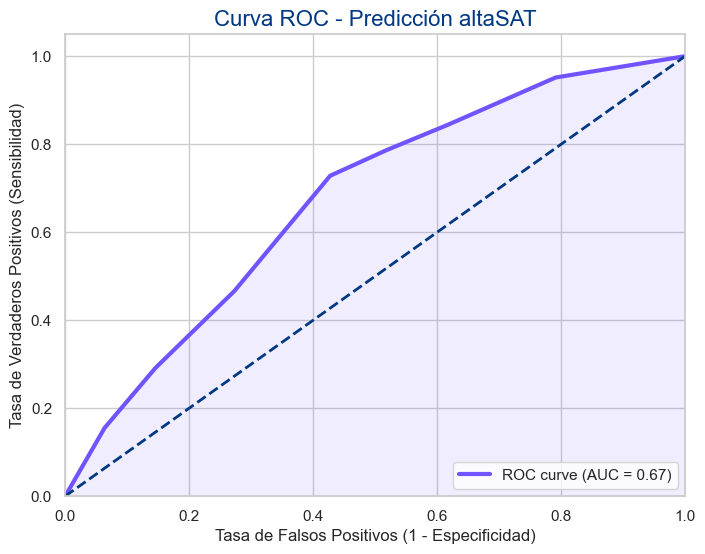

In [14]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color=VIBRANT_PURPLE, lw=3, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color=ALLIANZ_BLUE, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)', fontsize=12)
plt.title('Curva ROC - Predicción altaSAT', fontsize=16, color=ALLIANZ_BLUE)
plt.legend(loc="lower right")
plt.fill_between(fpr, tpr, alpha=0.1, color=VIBRANT_PURPLE)
plt.show()